# Project 4

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

We are going to focus on using listings with salary information to build a model and predict additional salaries.

##### Importing Packages

In [1]:
import pandas as pd
import numpy as np
from stop_words import get_stop_words
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import re

pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)

pd.set_option('precision', 2)

In [2]:
jobs_df = pd.read_csv('indeed-scraped-job-postings.csv')
jobs_df.head()

,city,company,salary,summary,title,parsed_salary
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5
2,Denver,Mental Health Center of Denver,"$70,000 - $80,000 a year",Advise the Data Developer with regard to creat...,Financial Data Scientist,75000.0
3,Denver,Denver Public Schools,"$62,712 - $75,255 a year",Portal managers on student outcome data report...,SENIOR RESEARCH ANALYST,68983.5
4,Denver,University of Colorado,"$25,000 - $29,000 a year",Experience entering and manipulating data in a...,Animal Care I,27000.0


In [3]:
jobs_df.shape

(413, 6)

In [4]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 6 columns):
city             413 non-null object
company          413 non-null object
salary           413 non-null object
summary          413 non-null object
title            413 non-null object
parsed_salary    406 non-null float64
dtypes: float64(1), object(5)
memory usage: 19.4+ KB


In [5]:
jobs_df['city'].unique()

array(['Denver', 'Austin', 'Seattle', 'Philadelphia', 'Palo+Alto',
       'Pittsburgh', 'Miami', 'Chicago', 'Dallas', 'San+Diego', 'New+York',
       'Boston', 'Los+Angeles', 'Phoenix', 'Houston', 'Portland',
       'San+Francisco', 'Atlanta'], dtype=object)

In [6]:
header = jobs_df.columns.tolist()
header

['city', 'company', 'salary', 'summary', 'title', 'parsed_salary']

In [7]:
uniques = [(col, jobs_df[col].nunique()) for col in header]
uniques

[('city', 18),
 ('company', 191),
 ('salary', 239),
 ('summary', 387),
 ('title', 337),
 ('parsed_salary', 163)]

#### Initial Impressions of dataset -- cleaning plan

Data set has job postings for data science jobs placed in 18 cities.  There are 413 rows and 6 columns.  The 'parsed_salary' column has 7 NaNs.  We are going to drop NaNs since these observations are related to job positings that did not have annual salary information.  They instead gave a per day wage rate.  We could extrapolate the per day wage rate into an annual salary, but because contractors generally do not receive benefits and there are taxation differences, we believe that this may cause us comparability issues.  Therefore, as there are only 7 NaNs instances, we are going to drop these instances.


In [8]:
jobs_df[jobs_df['parsed_salary'].isnull()]

,city,company,salary,summary,title,parsed_salary
41,Seattle,Arne Software,$100 a day,The successful candidate MUST have a PhD in St...,Data Scientist,NaN
123,Chicago,Real Staffing,$100 - $140 a day,Candidate is responsible to provide Big Data r...,IT Solution Architect,NaN
124,Chicago,RealIT,$100 - $140 a day,Candidate is responsible to provide Big Data r...,IT Solution Architect,NaN
189,New+York,Selby Jennings,$650 - $900 a day,Senior Quantitative Developer/Machine Learning...,Senior Quantitative/Machine Learning - Contract,NaN
310,Los+Angeles,Insight Recruiting,$140 - $160 a day,Fixed Income Research Analyst Research analyst...,Fixed Income Research Analyst,NaN
367,San+Francisco,"Projas Technologies, LLC",$70 - $95 a day,BA/BS degree in Computer Science preferred wit...,Senior Data Scientist (FTE or Contract to hire),NaN
389,San+Francisco,Global Placement Firm,$130 - $140 a day,This role is suited for a self-directed Senior...,Senior Web Research Scientist,NaN


In [9]:
jobs_df.shape

(413, 6)

In [10]:
jobs_df = jobs_df.dropna()
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406 entries, 0 to 412
Data columns (total 6 columns):
city             406 non-null object
company          406 non-null object
salary           406 non-null object
summary          406 non-null object
title            406 non-null object
parsed_salary    406 non-null float64
dtypes: float64(1), object(5)
memory usage: 22.2+ KB


In [11]:
jobs_df.head(2)

,city,company,salary,summary,title,parsed_salary
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5


## Feature Engineering

Our goal is to classify data science jobs by high salary and low salary based on a number of factors including title, location and information extracted from job summary text.

To this end, we will split `parsed_salary` into high and low.

We will define 'High Salary' as salaries greater than or equal to the median salary of 100,000 and 'Low Salary' as those below 100,000.  'High Salary' will be indicated by '1' and 'Low Salary' by '0'. 

In [12]:
jobs_df.describe()

,parsed_salary
count,406.00
mean,107762.70
std,48931.37
min,10000.00
25%,70000.00
50%,100000.00
75%,142164.50
max,300000.00


In [13]:
jobs_df['salary_class'] = jobs_df['parsed_salary'].apply(lambda x: 1 if x >= 100000 else 0)
jobs_df.head(5)

,city,company,salary,summary,title,parsed_salary,salary_class
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0,0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5,0
2,Denver,Mental Health Center of Denver,"$70,000 - $80,000 a year",Advise the Data Developer with regard to creat...,Financial Data Scientist,75000.0,0
3,Denver,Denver Public Schools,"$62,712 - $75,255 a year",Portal managers on student outcome data report...,SENIOR RESEARCH ANALYST,68983.5,0
4,Denver,University of Colorado,"$25,000 - $29,000 a year",Experience entering and manipulating data in a...,Animal Care I,27000.0,0


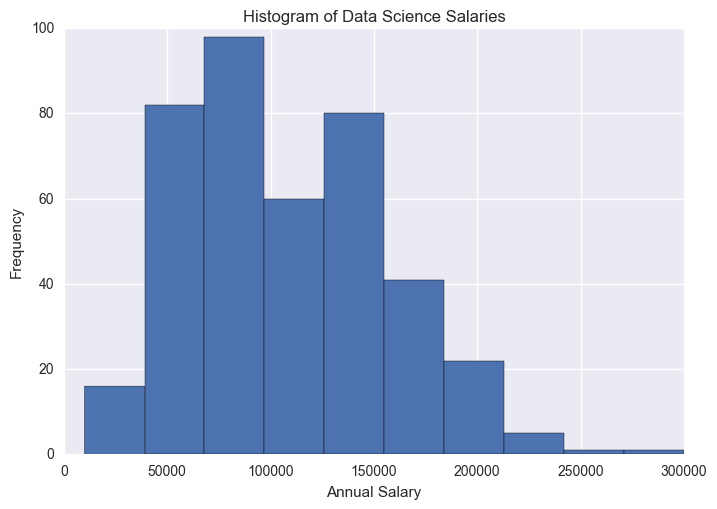

In [14]:
jobs_df['parsed_salary'].hist()
plt.title('Histogram of Data Science Salaries')
plt.xlabel('Annual Salary')
plt.ylabel('Frequency')

In [15]:
jobs_df['parsed_salary'].quantile(.75)

142164.5

Location is definitely a factor we want to study.  We will do so, by creating dummy variables for each city.  The one thing that gives me pause is our data set's small size.  There are 18 cities -- creating dummy variables for each may be an issue (it is easy enough via `pd.get_dummies`).  One idea would be to separate cities into high cost and low cost buckets.

https://www.expatistan.com/cost-of-living/index/north-america

High Cost (Rank):

- New York (1)
- San Francisco (2)
- Palo Alto (5) -- San Jose was the proxy
- Boston (6)
- Los Angeles (8)
- Seattle (9)
- San Diego (10)
- Chicago (11)
- Philadelphia (12)

We will create a new column 'city_COLA' for 'Cost of Living' -- High COLA cities = '1' and Low = '0'

In [16]:
high_COLA = ['New+York', 'San+Francisco', 'Palo+Alto', 
             'Boston', 'Los+Angeles', 'Seattle',
             'San+Diego', 'Chicago', 'Philadelphia']

In [17]:
jobs_df['city_COLA'] = jobs_df['city'].apply(lambda x: 1 if x in high_COLA else 0)
jobs_df.head(2)

,city,company,salary,summary,title,parsed_salary,salary_class,city_COLA
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0,0,0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5,0,0


In [18]:
jobs_df['city_COLA'].sum()

320

More than 3/4 of the job listings are for high cost cities

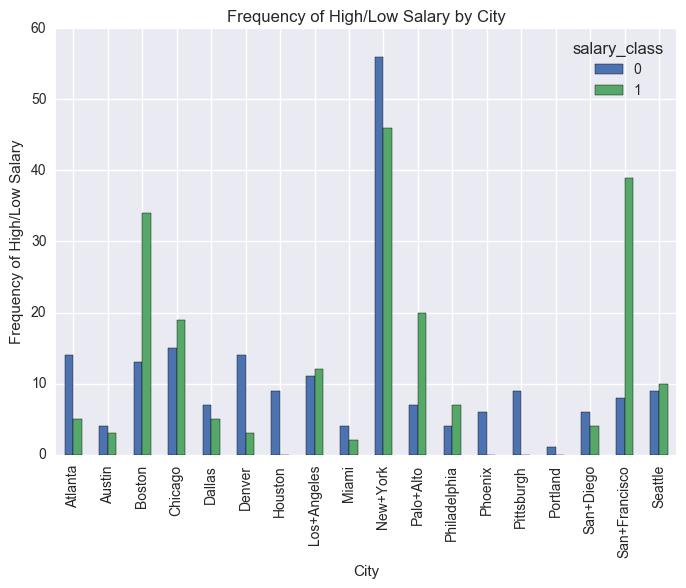

In [19]:
pd.crosstab(jobs_df['city'],jobs_df['salary_class']).plot(kind='bar')
plt.title('Frequency of High/Low Salary by City')
plt.xlabel('City')
plt.ylabel('Frequency of High/Low Salary')

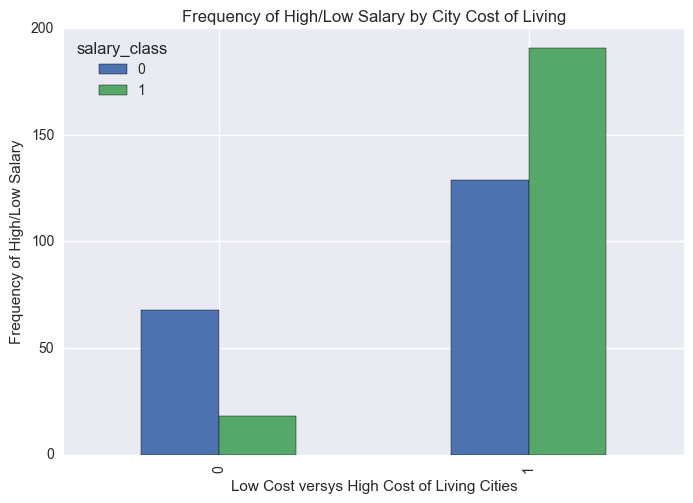

In [20]:
pd.crosstab(jobs_df['city_COLA'],jobs_df['salary_class']).plot(kind='bar')
plt.title('Frequency of High/Low Salary by City Cost of Living')
plt.xlabel('Low Cost versys High Cost of Living Cities')
plt.ylabel('Frequency of High/Low Salary')

In [21]:
jobs_by_city_df = jobs_df.groupby(by='city', as_index=False).agg({'parsed_salary': np.mean,
                                                'salary_class': np.mean})

In [22]:
jobs_by_city_df.sort_values(by='parsed_salary', axis=0, ascending=False)

,city,parsed_salary,salary_class
16,San+Francisco,141321.52,0.83
3,Chicago,118959.75,0.56
10,Palo+Alto,117267.33,0.74
2,Boston,116635.90,0.72
7,Los+Angeles,112636.26,0.52
17,Seattle,111225.21,0.53
9,New+York,107889.15,0.45
11,Philadelphia,105545.45,0.64
4,Dallas,97958.33,0.42
1,Austin,96571.43,0.43


### Extracting key words from 'summary' and 'title' columns

Write a function to tokenize words

In [23]:
jobs_df.head()

,city,company,salary,summary,title,parsed_salary,salary_class,city_COLA
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0,0,0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5,0,0
2,Denver,Mental Health Center of Denver,"$70,000 - $80,000 a year",Advise the Data Developer with regard to creat...,Financial Data Scientist,75000.0,0,0
3,Denver,Denver Public Schools,"$62,712 - $75,255 a year",Portal managers on student outcome data report...,SENIOR RESEARCH ANALYST,68983.5,0,0
4,Denver,University of Colorado,"$25,000 - $29,000 a year",Experience entering and manipulating data in a...,Animal Care I,27000.0,0,0


In [24]:
# converting 'summary' column to all lower case for ease of processing -- especially further down in code
# also doing the same for 'title' column

jobs_df['summary'] = jobs_df['summary'].str.lower()
jobs_df['title'] = jobs_df['title'].str.lower()

In [25]:
jobs_df.head(2)

,city,company,salary,summary,title,parsed_salary,salary_class,city_COLA
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","would you like to join the more than 10,000 sc...","statistician, gs-1350-12 (deu-perm-ds)",87792.0,0,0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",investigate potential uses of geospatial data ...,interdisciplinary cartographer/geographer - gs...,85127.5,0,0


In [26]:
def tokenize(text):
    text = text.lower() # converts text to lowercase   
    all_words = re.findall("[a-z]+", text) # extracts the words
    no_dupes = set(all_words) # remove duplicate words within each job posting
    return list(no_dupes)

In [27]:
jobs_df['summary_tmp'] = jobs_df['summary'].apply(tokenize)
jobs_df.head()

,city,company,salary,summary,title,parsed_salary,salary_class,city_COLA,summary_tmp
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","would you like to join the more than 10,000 sc...","statistician, gs-1350-12 (deu-perm-ds)",87792.0,0,0,"[and, working, join, like, would, of, support,..."
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",investigate potential uses of geospatial data ...,interdisciplinary cartographer/geographer - gs...,85127.5,0,0,"[and, geospatial, develop, to, of, procedures,..."
2,Denver,Mental Health Center of Denver,"$70,000 - $80,000 a year",advise the data developer with regard to creat...,financial data scientist,75000.0,0,0,"[and, tables, creation, for, needed, data, mak..."
3,Denver,Denver Public Schools,"$62,712 - $75,255 a year",portal managers on student outcome data report...,senior research analyst,68983.5,0,0,"[and, on, facilitates, validation, managers, a..."
4,Denver,University of Colorado,"$25,000 - $29,000 a year",experience entering and manipulating data in a...,animal care i,27000.0,0,0,"[and, a, we, used, animals, which, for, labora..."


In [28]:
# Putting all of the words from the 'summary' job descriptions into a list for processing
# Extracts list of words from each row of 'summary_tmp'
# 'summary_word_list' is a list of lists

summary_wordlist = []
for row in jobs_df['summary_tmp']:
    summary_wordlist.append(row)

len(summary_wordlist)

406

In [29]:
# Need to go from 406 lists to 1 'master list' of words from 'summary' job description text

summary_masterlist = []
for alist in summary_wordlist:
    for word in alist:
        summary_masterlist.append(word)

len(summary_masterlist)

7723

In [30]:
# going to filter 'summary_wordlist' by stop_words

from stop_words import get_stop_words

stop_words = get_stop_words('en')

summary_masterlist = [i for i in summary_masterlist if i not in stop_words]

len(summary_masterlist)

5571

In [31]:
# now that we have our cleaned up list of words -- look at the word counts to identify potential key words
# converting 'summary_masterlist' to a dataframe -- easier to manipulate and to count word frequencies

summary_masterlist_df = pd.DataFrame(summary_masterlist, columns=['Word'])
summary_masterlist_df['Word'].value_counts().to_frame()

,Word
data,348
scientist,119
scientists,66
research,65
analysis,62
will,59
experience,59
team,58
looking,56
analytics,39


In [32]:
jobs_df.head(2)

,city,company,salary,summary,title,parsed_salary,salary_class,city_COLA,summary_tmp
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","would you like to join the more than 10,000 sc...","statistician, gs-1350-12 (deu-perm-ds)",87792.0,0,0,"[and, working, join, like, would, of, support,..."
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",investigate potential uses of geospatial data ...,interdisciplinary cartographer/geographer - gs...,85127.5,0,0,"[and, geospatial, develop, to, of, procedures,..."


In [33]:
jobs_df['summary'].str.contains('data', re.IGNORECASE).sum()

348

In [34]:
summary_keylist = set(summary_masterlist)
len(summary_keylist)

1716

In [35]:
summary_keylist = list(summary_keylist)
summary_keylist

['limited',
 'desirable',
 'four',
 'facilities',
 'asian',
 'consists',
 'integrity',
 'relationships',
 'looking',
 'eligible',
 'presents',
 'matlab',
 'silicon',
 'collaborate',
 'risk',
 'physician',
 'updates',
 'school',
 'investigator',
 'skills',
 'companies',
 'solution',
 'enhance',
 'enjoy',
 'tired',
 'guidelines',
 'direct',
 'pulse',
 'budget',
 'feasibility',
 'implemented',
 'established',
 'selected',
 'profitability',
 'bonuses',
 'reconstruction',
 'conduct',
 'new',
 'net',
 'seeks',
 'specialist',
 'maintains',
 'mel',
 'protection',
 'studio',
 'interpret',
 'substance',
 'study',
 'reports',
 'experienceusing',
 'credit',
 'analysts',
 'campaign',
 'highly',
 'county',
 'visible',
 'unix',
 'total',
 'dna',
 'marketers',
 'hospital',
 'asset',
 'recommend',
 'assessment',
 'preparation',
 'advance',
 'successful',
 'brings',
 'award',
 'certifications',
 'excellent',
 'must',
 'join',
 'ml',
 'work',
 'concepts',
 'estate',
 'organized',
 'implementations',
 'in

#### Thoughts at this point:

Now that we have gotten our list of words in'summar' and have looked at the number of times they appear -- going to select the key words that are correlated to HIGH or LOW salary.

Although data, science, scientist(s), analysis are some of the most common words -- as these are data science job descriptions, they probably will not be a help in classification.  Overall, given the small size of the data set (406 instances) we want to be judicious in the number of features we use to avoid the curse of dimensionality.  

Ideally, wanted to regex to extract key phrases like x years experience -- but (a) could not get code to work and upon a manual check there were only two listings that gave that information.  I'm speculating that if both words appear in a job listing that would be a good proxy -- (e.g, years + experience).

First step is calculate correlation matrix of words that appear in `summary` text and `salary_class` and sort these correlations to select the best potential features.

##### This code creates a dataframe of key_words -- booleans line up whether or not they are in `summary` in `jobs_df`

In [36]:
sum_keywords_df = pd.DataFrame(dict((keyword, 
                                     jobs_df['summary'].str.contains(keyword))
                                     for keyword in summary_keylist
                                   ))
sum_keywords_df.head()

,abilities,ability,able,abuse,academic,acceleration,access,accessing,accordance,account,accountants,accounting,accounts,accuracy,accurate,accurately,achieve,acid,acl,across,act,action,actionable,activities,actuarial,acumen,ad,add,adding,addison,addition,additional,additionally,addressing,adjusted,adjusting,adjustments,administration,administrative,administrator,advance,advanced,advertising,advise,advisory,afraid,agencies,agency,aggregate,aggregation,agile,airbnb,algorithm,algorithmic,algorithms,allocation,allows,along,alongside,alpha,alphas,also,amazing,aml,among,amount,amounts,analyses,analysis,analyst,analysts,analytic,analytical,analytics,analyze,analyzing,anatomic,ancillary,animal,animals,anlysis,annual,answer,anti,apart,aphorism,api,apis,applicable,applicants,application,applications,applied,apply,applying,approach,approaches,appropriate,approved,apps,ar,architect,architects,architecture,archive,area,around,arrangements,art,artificial,arts,asian,aspect,assays,assessment,asset,assets,assigned,assist,assistant,assisting,assists,association,assurance,assure,audiences,audit,auditory,austin,automate,automated,automation,autonomous,availability,available,averityteam,award,awareness,away,aws,b,background,backgrounds,backup,bandwidth,bank,banking,base,based,baseline,basic,basis,bay,bayesian,beach,beautiful,become,behalf,behavioral,benchmark,benchmarks,benefit,benefits,best,better,bi,big,bigdata,billion,bioinformatic,biological,biomedical,biostatistic,biotech,biviumgroup,biz,blood,bonus,bonuses,booking,boosting,boston,boutique,bow,brand,breadth,breakdown,breaking,breeding,brilent,brilliant,bring,brings,brisbane,brokerage,budget,budgeting,build,building,builds,bureau,business,c,ca,caffe,calculation,california,calit,cambridge,campaign,campaigns,campus,can,candidate,candidates,capable,capture,card,care,case,cassandra,categorical,cdc,cell,center,centers,central,certifications,certifying,cfa,cgmp,chain,challenging,chandra,charts,check,checking,checks,chemical,chemistry,chicago,circa,city,clarity,class,classes,classification,clean,cleaning,cleansing,cleanup,click,client,clients,clinic,clinical,clipping,closely,closing,cloud,co,code,codes,coding,cognitive,collaborate,collaborative,collect,collected,collection,collects,college,colony,com,combining,comes,comfortable,comirb,commerce,commitment,committee,communicate,communicating,communication,companies,company,compare,compares,compelling,compensation,competence,compilation,compile,compiles,compiling,completeness,completion,complex,compliance,components,composed,compounds,comprehension,comprehensive,comprised,computer,computers,computing,concepts,conclusions,conditions,conduct,conducted,conducting,confidential,confirmation,conservation,considered,consists,constant,constantly,construction,consult,consultant,consultation,consultative,consulting,consumer,contactmichael,context,continuing,continuous,contract,contracts,contribute,control,conversion,cool,coordinate,coordination,core,corporation,correct,cost,costing,costs,county,crafting,create,creates,creating,creation,credit,crime,criteria,cross,crucial,culture,current,currently,custom,customer,cut,cutting,cxcds,d,daily,dashboarding,data,database,databases,datacenter,datasets,dealing,dec,decipher,decision,decisions,decrease,dedication,deep,define,degree,delinquent,deliver,delivering,delivery,demographic,demonstrated,demonstrates,department,depending,deployment,deposits,depth,derive,derived,des,describing,description,descriptive,design,designed,designthe,desirable,desired,detail,determine,dev,develop,developed,developer,developers,developing,development,developments,develops,device,devices,devises,devops,dictionaries,diego,different,difficult,digital,digitalglobe,direct,direction,directly,director,disciplinary,discipline,discover,discription,discussions,disease,disparate,disruptive,dissemination,distributed,district,diverse,division,dna,doctoral,doctors,document,documenting,documents,dollar,domain,downtown,draft,draw,drawing,drive,driven,drives,dr

#### Coding plan 

1. Binarize and create combination features if appropriate
1. Drop unnecessary columns
1. Merge to `jobs_df`

In [37]:
sum_keywords_df.shape

(406, 1716)

In [38]:
sum_header = sum_keywords_df.columns.tolist()

In [39]:
# Binarizing sum_keywords_df

for column in sum_header:
    sum_keywords_df[column] = sum_keywords_df[column].apply(lambda x: 1 if x==True else 0)

sum_keywords_df.head(10)

,abilities,ability,able,abuse,academic,acceleration,access,accessing,accordance,account,accountants,accounting,accounts,accuracy,accurate,accurately,achieve,acid,acl,across,act,action,actionable,activities,actuarial,acumen,ad,add,adding,addison,addition,additional,additionally,addressing,adjusted,adjusting,adjustments,administration,administrative,administrator,advance,advanced,advertising,advise,advisory,afraid,agencies,agency,aggregate,aggregation,agile,airbnb,algorithm,algorithmic,algorithms,allocation,allows,along,alongside,alpha,alphas,also,amazing,aml,among,amount,amounts,analyses,analysis,analyst,analysts,analytic,analytical,analytics,analyze,analyzing,anatomic,ancillary,animal,animals,anlysis,annual,answer,anti,apart,aphorism,api,apis,applicable,applicants,application,applications,applied,apply,applying,approach,approaches,appropriate,approved,apps,ar,architect,architects,architecture,archive,area,around,arrangements,art,artificial,arts,asian,aspect,assays,assessment,asset,assets,assigned,assist,assistant,assisting,assists,association,assurance,assure,audiences,audit,auditory,austin,automate,automated,automation,autonomous,availability,available,averityteam,award,awareness,away,aws,b,background,backgrounds,backup,bandwidth,bank,banking,base,based,baseline,basic,basis,bay,bayesian,beach,beautiful,become,behalf,behavioral,benchmark,benchmarks,benefit,benefits,best,better,bi,big,bigdata,billion,bioinformatic,biological,biomedical,biostatistic,biotech,biviumgroup,biz,blood,bonus,bonuses,booking,boosting,boston,boutique,bow,brand,breadth,breakdown,breaking,breeding,brilent,brilliant,bring,brings,brisbane,brokerage,budget,budgeting,build,building,builds,bureau,business,c,ca,caffe,calculation,california,calit,cambridge,campaign,campaigns,campus,can,candidate,candidates,capable,capture,card,care,case,cassandra,categorical,cdc,cell,center,centers,central,certifications,certifying,cfa,cgmp,chain,challenging,chandra,charts,check,checking,checks,chemical,chemistry,chicago,circa,city,clarity,class,classes,classification,clean,cleaning,cleansing,cleanup,click,client,clients,clinic,clinical,clipping,closely,closing,cloud,co,code,codes,coding,cognitive,collaborate,collaborative,collect,collected,collection,collects,college,colony,com,combining,comes,comfortable,comirb,commerce,commitment,committee,communicate,communicating,communication,companies,company,compare,compares,compelling,compensation,competence,compilation,compile,compiles,compiling,completeness,completion,complex,compliance,components,composed,compounds,comprehension,comprehensive,comprised,computer,computers,computing,concepts,conclusions,conditions,conduct,conducted,conducting,confidential,confirmation,conservation,considered,consists,constant,constantly,construction,consult,consultant,consultation,consultative,consulting,consumer,contactmichael,context,continuing,continuous,contract,contracts,contribute,control,conversion,cool,coordinate,coordination,core,corporation,correct,cost,costing,costs,county,crafting,create,creates,creating,creation,credit,crime,criteria,cross,crucial,culture,current,currently,custom,customer,cut,cutting,cxcds,d,daily,dashboarding,data,database,databases,datacenter,datasets,dealing,dec,decipher,decision,decisions,decrease,dedication,deep,define,degree,delinquent,deliver,delivering,delivery,demographic,demonstrated,demonstrates,department,depending,deployment,deposits,depth,derive,derived,des,describing,description,descriptive,design,designed,designthe,desirable,desired,detail,determine,dev,develop,developed,developer,developers,developing,development,developments,develops,device,devices,devises,devops,dictionaries,diego,different,difficult,digital,digitalglobe,direct,direction,directly,director,disciplinary,discipline,discover,discription,discussions,disease,disparate,disruptive,dissemination,distributed,district,diverse,division,dna,doctoral,doctors,document,documenting,documents,dollar,domain,downtown,draft,draw,drawing,drive,driven,drives,dr

In [40]:
sum_keywords_df.shape

(406, 1716)

In [41]:
# Confirming counts - by using the str.contains - 'scientist' includes 'scientists'

sum_keywords_df[(sum_keywords_df['scientist']==1) | (sum_keywords_df['scientists']==1)].shape

(178, 1716)

In [42]:
# Adding combination columns - years + experience may be a good proxy for years experience

sum_keywords_df['years_experience'] = np.where(np.logical_and(sum_keywords_df['years']==1,
                                                               sum_keywords_df['experience']==1),
                                                               1,
                                                               0)

Now adding high/low salary to `summary_keywords_df` so can run a correlation matrix and sort by highest to select features

In [43]:
sum_keywords_df['salary_class'] = jobs_df['salary_class']
sum_keywords_df.head(2)

,abilities,ability,able,abuse,academic,acceleration,access,accessing,accordance,account,accountants,accounting,accounts,accuracy,accurate,accurately,achieve,acid,acl,across,act,action,actionable,activities,actuarial,acumen,ad,add,adding,addison,addition,additional,additionally,addressing,adjusted,adjusting,adjustments,administration,administrative,administrator,advance,advanced,advertising,advise,advisory,afraid,agencies,agency,aggregate,aggregation,agile,airbnb,algorithm,algorithmic,algorithms,allocation,allows,along,alongside,alpha,alphas,also,amazing,aml,among,amount,amounts,analyses,analysis,analyst,analysts,analytic,analytical,analytics,analyze,analyzing,anatomic,ancillary,animal,animals,anlysis,annual,answer,anti,apart,aphorism,api,apis,applicable,applicants,application,applications,applied,apply,applying,approach,approaches,appropriate,approved,apps,ar,architect,architects,architecture,archive,area,around,arrangements,art,artificial,arts,asian,aspect,assays,assessment,asset,assets,assigned,assist,assistant,assisting,assists,association,assurance,assure,audiences,audit,auditory,austin,automate,automated,automation,autonomous,availability,available,averityteam,award,awareness,away,aws,b,background,backgrounds,backup,bandwidth,bank,banking,base,based,baseline,basic,basis,bay,bayesian,beach,beautiful,become,behalf,behavioral,benchmark,benchmarks,benefit,benefits,best,better,bi,big,bigdata,billion,bioinformatic,biological,biomedical,biostatistic,biotech,biviumgroup,biz,blood,bonus,bonuses,booking,boosting,boston,boutique,bow,brand,breadth,breakdown,breaking,breeding,brilent,brilliant,bring,brings,brisbane,brokerage,budget,budgeting,build,building,builds,bureau,business,c,ca,caffe,calculation,california,calit,cambridge,campaign,campaigns,campus,can,candidate,candidates,capable,capture,card,care,case,cassandra,categorical,cdc,cell,center,centers,central,certifications,certifying,cfa,cgmp,chain,challenging,chandra,charts,check,checking,checks,chemical,chemistry,chicago,circa,city,clarity,class,classes,classification,clean,cleaning,cleansing,cleanup,click,client,clients,clinic,clinical,clipping,closely,closing,cloud,co,code,codes,coding,cognitive,collaborate,collaborative,collect,collected,collection,collects,college,colony,com,combining,comes,comfortable,comirb,commerce,commitment,committee,communicate,communicating,communication,companies,company,compare,compares,compelling,compensation,competence,compilation,compile,compiles,compiling,completeness,completion,complex,compliance,components,composed,compounds,comprehension,comprehensive,comprised,computer,computers,computing,concepts,conclusions,conditions,conduct,conducted,conducting,confidential,confirmation,conservation,considered,consists,constant,constantly,construction,consult,consultant,consultation,consultative,consulting,consumer,contactmichael,context,continuing,continuous,contract,contracts,contribute,control,conversion,cool,coordinate,coordination,core,corporation,correct,cost,costing,costs,county,crafting,create,creates,creating,creation,credit,crime,criteria,cross,crucial,culture,current,currently,custom,customer,cut,cutting,cxcds,d,daily,dashboarding,data,database,databases,datacenter,datasets,dealing,dec,decipher,decision,decisions,decrease,dedication,deep,define,degree,delinquent,deliver,delivering,delivery,demographic,demonstrated,demonstrates,department,depending,deployment,deposits,depth,derive,derived,des,describing,description,descriptive,design,designed,designthe,desirable,desired,detail,determine,dev,develop,developed,developer,developers,developing,development,developments,develops,device,devices,devises,devops,dictionaries,diego,different,difficult,digital,digitalglobe,direct,direction,directly,director,disciplinary,discipline,discover,discription,discussions,disease,disparate,disruptive,dissemination,distributed,district,diverse,division,dna,doctoral,doctors,document,documenting,documents,dollar,domain,downtown,draft,draw,drawing,drive,driven,drives,dr

#### Sort Parameters by their Correlation with 'salary_class' - dependent variable

In [44]:
sum_keywords_correlations = abs(sum_keywords_df.corr()['salary_class'])
sum_keywords_correlations.sort_values(inplace=True, ascending=False)
sum_keywords_correlations.head(25)

salary_class    1.00
team            0.28
scientist       0.25
looking         0.25
lead            0.23
engineer        0.23
company         0.22
engine          0.22
senior          0.20
project         0.20
model           0.19
leading         0.19
learn           0.19
learning        0.18
research        0.18
report          0.18
present         0.18
search          0.17
one             0.16
ad              0.16
role            0.16
modeling        0.16
build           0.16
big             0.16
machine         0.15
Name: salary_class, dtype: float64

From the correlation matrix -- `salary_class` -- the following words look like promising features.

- engineer
- lead
- company (may differentiate between private (high salary) and public (low salary) jobs
- senior
- learn
- research
- model
- big
- machine

Thinking is may not include data and scientist as this may be redundant given these are data science jobs

Now adding `parsed_salary` to `sum_keywords_df` to see if correlations are stronger on actual salary numbers than `salary_class`

In [45]:
sum_keywords_df['salary_corr'] = jobs_df['parsed_salary']
sum_keywords_df.head(2)

,abilities,ability,able,abuse,academic,acceleration,access,accessing,accordance,account,accountants,accounting,accounts,accuracy,accurate,accurately,achieve,acid,acl,across,act,action,actionable,activities,actuarial,acumen,ad,add,adding,addison,addition,additional,additionally,addressing,adjusted,adjusting,adjustments,administration,administrative,administrator,advance,advanced,advertising,advise,advisory,afraid,agencies,agency,aggregate,aggregation,agile,airbnb,algorithm,algorithmic,algorithms,allocation,allows,along,alongside,alpha,alphas,also,amazing,aml,among,amount,amounts,analyses,analysis,analyst,analysts,analytic,analytical,analytics,analyze,analyzing,anatomic,ancillary,animal,animals,anlysis,annual,answer,anti,apart,aphorism,api,apis,applicable,applicants,application,applications,applied,apply,applying,approach,approaches,appropriate,approved,apps,ar,architect,architects,architecture,archive,area,around,arrangements,art,artificial,arts,asian,aspect,assays,assessment,asset,assets,assigned,assist,assistant,assisting,assists,association,assurance,assure,audiences,audit,auditory,austin,automate,automated,automation,autonomous,availability,available,averityteam,award,awareness,away,aws,b,background,backgrounds,backup,bandwidth,bank,banking,base,based,baseline,basic,basis,bay,bayesian,beach,beautiful,become,behalf,behavioral,benchmark,benchmarks,benefit,benefits,best,better,bi,big,bigdata,billion,bioinformatic,biological,biomedical,biostatistic,biotech,biviumgroup,biz,blood,bonus,bonuses,booking,boosting,boston,boutique,bow,brand,breadth,breakdown,breaking,breeding,brilent,brilliant,bring,brings,brisbane,brokerage,budget,budgeting,build,building,builds,bureau,business,c,ca,caffe,calculation,california,calit,cambridge,campaign,campaigns,campus,can,candidate,candidates,capable,capture,card,care,case,cassandra,categorical,cdc,cell,center,centers,central,certifications,certifying,cfa,cgmp,chain,challenging,chandra,charts,check,checking,checks,chemical,chemistry,chicago,circa,city,clarity,class,classes,classification,clean,cleaning,cleansing,cleanup,click,client,clients,clinic,clinical,clipping,closely,closing,cloud,co,code,codes,coding,cognitive,collaborate,collaborative,collect,collected,collection,collects,college,colony,com,combining,comes,comfortable,comirb,commerce,commitment,committee,communicate,communicating,communication,companies,company,compare,compares,compelling,compensation,competence,compilation,compile,compiles,compiling,completeness,completion,complex,compliance,components,composed,compounds,comprehension,comprehensive,comprised,computer,computers,computing,concepts,conclusions,conditions,conduct,conducted,conducting,confidential,confirmation,conservation,considered,consists,constant,constantly,construction,consult,consultant,consultation,consultative,consulting,consumer,contactmichael,context,continuing,continuous,contract,contracts,contribute,control,conversion,cool,coordinate,coordination,core,corporation,correct,cost,costing,costs,county,crafting,create,creates,creating,creation,credit,crime,criteria,cross,crucial,culture,current,currently,custom,customer,cut,cutting,cxcds,d,daily,dashboarding,data,database,databases,datacenter,datasets,dealing,dec,decipher,decision,decisions,decrease,dedication,deep,define,degree,delinquent,deliver,delivering,delivery,demographic,demonstrated,demonstrates,department,depending,deployment,deposits,depth,derive,derived,des,describing,description,descriptive,design,designed,designthe,desirable,desired,detail,determine,dev,develop,developed,developer,developers,developing,development,developments,develops,device,devices,devises,devops,dictionaries,diego,different,difficult,digital,digitalglobe,direct,direction,directly,director,disciplinary,discipline,discover,discription,discussions,disease,disparate,disruptive,dissemination,distributed,district,diverse,division,dna,doctoral,doctors,document,documenting,documents,dollar,domain,downtown,draft,draw,drawing,drive,driven,drives,dr

In [46]:
sum_keywords_df.shape

(406, 1719)

In [47]:
sum_keywords_correlations1 = abs(sum_keywords_df.corr()['salary_corr'])
sum_keywords_correlations1.sort_values(inplace=True, ascending=False)
sum_keywords_correlations1.head(25)

salary_corr     1.00
salary_class    0.83
lead            0.32
team            0.31
leading         0.27
company         0.25
looking         0.25
scientist       0.25
model           0.24
ad              0.24
senior          0.21
modeling        0.21
engineer        0.20
included        0.20
science         0.19
engine          0.19
learn           0.19
learning        0.19
predictive      0.19
machine         0.17
teams           0.17
project         0.17
role            0.17
ny              0.17
collect         0.17
Name: salary_corr, dtype: float64

From the correlation matricies -- `salary_class` -- the following words look like promising features.

- engineer
- lead (companies that describe themselves as a leader or leading may be bigger and pay higher salaries
- company (may differentiate between private (high salary) and public (low salary) jobs
- senior
- learn
- research
- model
- big
- machine
- predictive

Thinking is may not include data and scientist as this may be redundant given these are data science jobs

#### Selecting the features we want from keywords in `summary` text

In [48]:
selected_sum = ['engineer', 
                'lead', 
                'company', 
                'senior', 
                'learn', 
                'research', 
                'model', 
                'big', 
                'machine',
                'predictive'
               ]

In [49]:
summary_cols_df = sum_keywords_df[selected_sum]

In [50]:
summary_cols_df.head()

,engineer,lead,company,senior,learn,research,model,big,machine,predictive
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [51]:
summary_cols_df.shape

(406, 10)

Now we are going to merge our key word dummies from the summary text to our main DataFrame -- `jobs_df`

Before doing so, want to rename column names to make it easy to identify these features are associated with the `summary` text as we are going to go through the same process for the `title` text

In [52]:
sum_cols_header = summary_cols_df.columns.tolist()
print sum_cols_header

['engineer', 'lead', 'company', 'senior', 'learn', 'research', 'model', 'big', 'machine', 'predictive']


In [53]:
new_sum_cols_header = []
for column in sum_cols_header:
    new_colname = 's_'+column 
    new_sum_cols_header.append(new_colname)

new_sum_cols_header

['s_engineer',
 's_lead',
 's_company',
 's_senior',
 's_learn',
 's_research',
 's_model',
 's_big',
 's_machine',
 's_predictive']

In [54]:
# Renaming the column headings

summary_cols_df.columns = new_sum_cols_header

summary_cols_df.head(2)

,s_engineer,s_lead,s_company,s_senior,s_learn,s_research,s_model,s_big,s_machine,s_predictive
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0


In [55]:
# before merging, first need to confirm both DataFrames have the same number of rows

jobs_df.shape, summary_cols_df.shape

((406, 9), (406, 10))

In [56]:
# merging using pd.concat

jobs_sum_df = pd.concat([jobs_df, summary_cols_df], axis=1)
jobs_sum_df.head(2)

,city,company,salary,summary,title,parsed_salary,salary_class,city_COLA,summary_tmp,s_engineer,s_lead,s_company,s_senior,s_learn,s_research,s_model,s_big,s_machine,s_predictive
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","would you like to join the more than 10,000 sc...","statistician, gs-1350-12 (deu-perm-ds)",87792.0,0,0,"[and, working, join, like, would, of, support,...",0,0,0,0,0,0,0,0,0,0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",investigate potential uses of geospatial data ...,interdisciplinary cartographer/geographer - gs...,85127.5,0,0,"[and, geospatial, develop, to, of, procedures,...",0,0,0,0,0,0,0,0,0,0


In [57]:
jobs_sum_df.shape

(406, 19)

## Now repeat the process for `title` text -- then prepare the feature matrix

In [58]:
# applying tokenize function to the 'title' column

jobs_df['title_tmp'] = jobs_df['title'].apply(tokenize)
jobs_df.head(2)

,city,company,salary,summary,title,parsed_salary,salary_class,city_COLA,summary_tmp,title_tmp
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","would you like to join the more than 10,000 sc...","statistician, gs-1350-12 (deu-perm-ds)",87792.0,0,0,"[and, working, join, like, would, of, support,...","[statistician, gs, deu, perm, ds]"
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",investigate potential uses of geospatial data ...,interdisciplinary cartographer/geographer - gs...,85127.5,0,0,"[and, geospatial, develop, to, of, procedures,...","[cartographer, gs, geographer, interdisciplinary]"


In [59]:
# Putting all of the words from the 'title' descriptions into a list for processing
# Extracts list of words from each row of 'title_tmp'
# 'title_word_list' is a list of lists

title_wordlist = []
for row in jobs_df['title_tmp']:
    title_wordlist.append(row)

len(title_wordlist)

406

In [60]:
# Need to go from 406 lists to 1 'master list' of words from 'title' job description text

title_masterlist = []
for alist in title_wordlist:
    for word in alist:
        title_masterlist.append(word)

len(title_masterlist)

1623

In [61]:
# going to filter 'title_wordlist' by stop_words

title_masterlist = [i for i in title_masterlist if i not in stop_words]

len(title_masterlist)

1556

In [62]:
# now that we have our cleaned up list of words -- look at the word counts to identify potential key words
# converting 'title_masterlist' to a dataframe -- easier to manipulate and to count word frequencies

title_masterlist_df = pd.DataFrame(title_masterlist, columns=['Word'])
title_masterlist_df['Word'].value_counts().to_frame()

,Word
data,160
scientist,151
analyst,84
research,80
senior,58
engineer,44
learning,28
machine,26
manager,25
software,20


In [63]:
jobs_df['title'].str.contains('senior', re.IGNORECASE).sum()

58

In [64]:
title_keylist = set(title_masterlist)

In [65]:
len(title_keylist)

427

In [66]:
title_keylist = list(title_keylist)
title_keylist

['coach',
 'gs',
 'sch',
 'chain',
 'global',
 'focus',
 'manager',
 'welfare',
 'flask',
 'program',
 'must',
 'resources',
 'ingredient',
 'division',
 'risk',
 'psychologist',
 'upstream',
 'school',
 'scholar',
 'level',
 'skills',
 'large',
 'geospatial',
 'team',
 'biological',
 'dir',
 'tea',
 'investment',
 'chicago',
 'ast',
 'certificated',
 'scientists',
 'new',
 'net',
 'principal',
 'public',
 'specialist',
 'full',
 'water',
 'astrophysicist',
 'teacher',
 'asc',
 'search',
 'institute',
 'k',
 'compliance',
 'experience',
 'credit',
 'survey',
 'analysts',
 'cto',
 'involves',
 'family',
 'deputy',
 'app',
 'grade',
 'tools',
 'cloud',
 'flavors',
 'devops',
 'perm',
 'asset',
 'vehicle',
 'citywide',
 'assessment',
 'company',
 'hedgefund',
 'training',
 'realty',
 'iii',
 'insights',
 'customer',
 'backgroun',
 'account',
 'claims',
 'geographer',
 'science',
 'des',
 'deu',
 'dev',
 'ms',
 'disabilities',
 'control',
 'estate',
 'high',
 'information',
 'end',
 'equit

In [67]:
title_keywords_df = pd.DataFrame(dict((keyword, 
                                     jobs_df['title'].str.contains(keyword))
                                     for keyword in title_keylist
                                   ))
title_keywords_df.head()

,academic,acce,account,accountant,actuary,administrat,administrative,administrator,adolescent,advanced,affairs,ai,algo,aml,analysis,analyst,analysts,analytics,angula,animal,app,applications,appsw,ar,architect,area,asc,assessment,asset,assistant,associate,asst,assurance,ast,astrophysicist,audit,autonomous,avp,aws,b,backgroun,bank,banking,bay,bayesian,behavioral,benefits,bi,big,billing,billion,bioinformatics,biological,biologics,biotech,budget,bureau,business,c,cards,care,career,cartographer,certificated,certifying,chain,chemical,chemist,chicago,chief,child,chronic,citywide,claims,client,clinical,cloud,cls,cnup,coach,coding,college,company,compensation,competitive,compliance,computer,consultant,contract,control,conversion,coordina,coordinator,credit,cto,custom,customer,cytometry,d,da,data,database,decision,deep,department,dept,deputy,des,deu,dev,developer,development,developmental,devices,devops,diego,diem,digital,dir,director,disabilities,disease,distributed,division,doctoral,document,ds,dyfj,econometrics,education,eeg,electronics,embedded,employee,end,energy,engineer,engineering,engineers,entry,environmental,epidemiologist,equities,equity,erlang,estate,etl,ev,evaluation,excel,exciting,exempt,experience,expert,exploratory,facing,family,fellow,financial,firm,fitness,flask,flavors,florida,focus,food,foodservice,formulation,fort,fraud,frequency,front,fu,full,fund,fundamental,g,geographer,geologist,geospatial,global,grade,gs,gse,hacking,hadoop,hand,head,health,healthcare,hed,hedge,hedgefund,high,hr,human,hybrid,ii,iii,il,includes,industry,infectious,inferen,information,ingredient,insights,institute,insurance,intelligence,interdisciplinary,international,internship,investment,involves,iv,java,jg,job,jr,js,junior,k,kendall,lab,laboratory,labs,language,large,lauderdale,lc,lead,learni,learning,lecturer,level,life,linux,long,machine,management,manager,manufactur,mapping,market,marketing,masters,mature,meat,media,medical,medicine,methodologist,mid,middle,mix,mobile,model,modeler,modeling,molecular,ms,must,n,natural,net,new,nlp,node,nsf,office,officer,omics,operations,opps,ops,optometry,organics,partially,payment,per,performing,perm,pharma,phd,phoenix,physical,plaines,platform,policy,pollution,post,postdoc,postdoctoral,ppc,pr,predictive,president,prevention,primary,principal,processes,processing,product,products,professional,program,programmer,programs,project,projects,protein,prov,psychologist,public,python,qa,quality,quant,quantitative,r,ra,rad,radars,rails,react,real,realty,regulatory,remote,renowned,reporting,rese,research,researcher,resources,revenue,right,risk,robotics,ruby,s,san,sc,scala,sch,scholar,school,science,sciences,scientific,scientist,scientists,screening,search,security,senior,seo,series,serv,service,services,skills,snr,software,specialist,sponsored,sql,square,sr,stack,staff,start,startup,statistical,statistician,statistics,stealth,stocks,strategic,strategy,strengthening,supervisory,supply,survey,systems,tea,teacher,team,tech,technical,technician,technologist,technology,term,test,throughput,time,tissue,title,tobac,tools,top,toxicologist,toxicology,trace,trading,training,ui,unit,upstream,us,validation,vc,vehicle,vice,virology,vision,vp,vr,water,web,welfare,wellness,world,ymj,york
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Tru

In [68]:
title_keywords_df.shape

(406, 427)

In [69]:
title_header = title_keywords_df.columns.tolist()

In [70]:
# binarizing title_header

for column in title_header:
    title_keywords_df[column] = title_keywords_df[column].apply(lambda x: 1 if x==True else 0)

title_keywords_df.head(10)

,academic,acce,account,accountant,actuary,administrat,administrative,administrator,adolescent,advanced,affairs,ai,algo,aml,analysis,analyst,analysts,analytics,angula,animal,app,applications,appsw,ar,architect,area,asc,assessment,asset,assistant,associate,asst,assurance,ast,astrophysicist,audit,autonomous,avp,aws,b,backgroun,bank,banking,bay,bayesian,behavioral,benefits,bi,big,billing,billion,bioinformatics,biological,biologics,biotech,budget,bureau,business,c,cards,care,career,cartographer,certificated,certifying,chain,chemical,chemist,chicago,chief,child,chronic,citywide,claims,client,clinical,cloud,cls,cnup,coach,coding,college,company,compensation,competitive,compliance,computer,consultant,contract,control,conversion,coordina,coordinator,credit,cto,custom,customer,cytometry,d,da,data,database,decision,deep,department,dept,deputy,des,deu,dev,developer,development,developmental,devices,devops,diego,diem,digital,dir,director,disabilities,disease,distributed,division,doctoral,document,ds,dyfj,econometrics,education,eeg,electronics,embedded,employee,end,energy,engineer,engineering,engineers,entry,environmental,epidemiologist,equities,equity,erlang,estate,etl,ev,evaluation,excel,exciting,exempt,experience,expert,exploratory,facing,family,fellow,financial,firm,fitness,flask,flavors,florida,focus,food,foodservice,formulation,fort,fraud,frequency,front,fu,full,fund,fundamental,g,geographer,geologist,geospatial,global,grade,gs,gse,hacking,hadoop,hand,head,health,healthcare,hed,hedge,hedgefund,high,hr,human,hybrid,ii,iii,il,includes,industry,infectious,inferen,information,ingredient,insights,institute,insurance,intelligence,interdisciplinary,international,internship,investment,involves,iv,java,jg,job,jr,js,junior,k,kendall,lab,laboratory,labs,language,large,lauderdale,lc,lead,learni,learning,lecturer,level,life,linux,long,machine,management,manager,manufactur,mapping,market,marketing,masters,mature,meat,media,medical,medicine,methodologist,mid,middle,mix,mobile,model,modeler,modeling,molecular,ms,must,n,natural,net,new,nlp,node,nsf,office,officer,omics,operations,opps,ops,optometry,organics,partially,payment,per,performing,perm,pharma,phd,phoenix,physical,plaines,platform,policy,pollution,post,postdoc,postdoctoral,ppc,pr,predictive,president,prevention,primary,principal,processes,processing,product,products,professional,program,programmer,programs,project,projects,protein,prov,psychologist,public,python,qa,quality,quant,quantitative,r,ra,rad,radars,rails,react,real,realty,regulatory,remote,renowned,reporting,rese,research,researcher,resources,revenue,right,risk,robotics,ruby,s,san,sc,scala,sch,scholar,school,science,sciences,scientific,scientist,scientists,screening,search,security,senior,seo,series,serv,service,services,skills,snr,software,specialist,sponsored,sql,square,sr,stack,staff,start,startup,statistical,statistician,statistics,stealth,stocks,strategic,strategy,strengthening,supervisory,supply,survey,systems,tea,teacher,team,tech,technical,technician,technologist,technology,term,test,throughput,time,tissue,title,tobac,tools,top,toxicologist,toxicology,trace,trading,training,ui,unit,upstream,us,validation,vc,vehicle,vice,virology,vision,vp,vr,water,web,welfare,wellness,world,ymj,york
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [71]:
title_keywords_df['data'].sum()

161

Now adding high/low salary to 'title_keywords_df' so can run a correlation matrix and sort by highest to select features

In [72]:
title_keywords_df['salary_class'] = jobs_df['salary_class']
title_keywords_df.head(2)

,academic,acce,account,accountant,actuary,administrat,administrative,administrator,adolescent,advanced,affairs,ai,algo,aml,analysis,analyst,analysts,analytics,angula,animal,app,applications,appsw,ar,architect,area,asc,assessment,asset,assistant,associate,asst,assurance,ast,astrophysicist,audit,autonomous,avp,aws,b,backgroun,bank,banking,bay,bayesian,behavioral,benefits,bi,big,billing,billion,bioinformatics,biological,biologics,biotech,budget,bureau,business,c,cards,care,career,cartographer,certificated,certifying,chain,chemical,chemist,chicago,chief,child,chronic,citywide,claims,client,clinical,cloud,cls,cnup,coach,coding,college,company,compensation,competitive,compliance,computer,consultant,contract,control,conversion,coordina,coordinator,credit,cto,custom,customer,cytometry,d,da,data,database,decision,deep,department,dept,deputy,des,deu,dev,developer,development,developmental,devices,devops,diego,diem,digital,dir,director,disabilities,disease,distributed,division,doctoral,document,ds,dyfj,econometrics,education,eeg,electronics,embedded,employee,end,energy,engineer,engineering,engineers,entry,environmental,epidemiologist,equities,equity,erlang,estate,etl,ev,evaluation,excel,exciting,exempt,experience,expert,exploratory,facing,family,fellow,financial,firm,fitness,flask,flavors,florida,focus,food,foodservice,formulation,fort,fraud,frequency,front,fu,full,fund,fundamental,g,geographer,geologist,geospatial,global,grade,gs,gse,hacking,hadoop,hand,head,health,healthcare,hed,hedge,hedgefund,high,hr,human,hybrid,ii,iii,il,includes,industry,infectious,inferen,information,ingredient,insights,institute,insurance,intelligence,interdisciplinary,international,internship,investment,involves,iv,java,jg,job,jr,js,junior,k,kendall,lab,laboratory,labs,language,large,lauderdale,lc,lead,learni,learning,lecturer,level,life,linux,long,machine,management,manager,manufactur,mapping,market,marketing,masters,mature,meat,media,medical,medicine,methodologist,mid,middle,mix,mobile,model,modeler,modeling,molecular,ms,must,n,natural,net,new,nlp,node,nsf,office,officer,omics,operations,opps,ops,optometry,organics,partially,payment,per,performing,perm,pharma,phd,phoenix,physical,plaines,platform,policy,pollution,post,postdoc,postdoctoral,ppc,pr,predictive,president,prevention,primary,principal,processes,processing,product,products,professional,program,programmer,programs,project,projects,protein,prov,psychologist,public,python,qa,quality,quant,quantitative,r,ra,rad,radars,rails,react,real,realty,regulatory,remote,renowned,reporting,rese,research,researcher,resources,revenue,right,risk,robotics,ruby,s,san,sc,scala,sch,scholar,school,science,sciences,scientific,scientist,scientists,screening,search,security,senior,seo,series,serv,service,services,skills,snr,software,specialist,sponsored,sql,square,sr,stack,staff,start,startup,statistical,statistician,statistics,stealth,stocks,strategic,strategy,strengthening,supervisory,supply,survey,systems,tea,teacher,team,tech,technical,technician,technologist,technology,term,test,throughput,time,tissue,title,tobac,tools,top,toxicologist,toxicology,trace,trading,training,ui,unit,upstream,us,validation,vc,vehicle,vice,virology,vision,vp,vr,water,web,welfare,wellness,world,ymj,york,salary_class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [73]:
title_keywords_df.shape

(406, 428)

#### Sort Parameters by their Correlation with 'salary_class' - dependent variable

In [74]:
title_keywords_correlations = abs(title_keywords_df.corr()['salary_class'])
title_keywords_correlations.sort_values(inplace=True, ascending=False)
title_keywords_correlations.head(25)

salary_class    1.00
scientist       0.38
data            0.38
da              0.38
rese            0.35
search          0.35
sc              0.35
research        0.35
d               0.31
analyst         0.26
ra              0.21
ar              0.21
assistant       0.19
senior          0.17
quant           0.16
quantitative    0.16
iv              0.16
engineer        0.15
fu              0.15
tech            0.14
specialist      0.14
vp              0.14
python          0.14
technician      0.14
learni          0.14
Name: salary_class, dtype: float64

Now adding `parsed_salary` to 'title_keywords_df' to see if correlations are stronger on actual salary numbers than `salary_class`

In [75]:
title_keywords_df['salary_corr'] = jobs_df['parsed_salary']
title_keywords_df.head(2)

,academic,acce,account,accountant,actuary,administrat,administrative,administrator,adolescent,advanced,affairs,ai,algo,aml,analysis,analyst,analysts,analytics,angula,animal,app,applications,appsw,ar,architect,area,asc,assessment,asset,assistant,associate,asst,assurance,ast,astrophysicist,audit,autonomous,avp,aws,b,backgroun,bank,banking,bay,bayesian,behavioral,benefits,bi,big,billing,billion,bioinformatics,biological,biologics,biotech,budget,bureau,business,c,cards,care,career,cartographer,certificated,certifying,chain,chemical,chemist,chicago,chief,child,chronic,citywide,claims,client,clinical,cloud,cls,cnup,coach,coding,college,company,compensation,competitive,compliance,computer,consultant,contract,control,conversion,coordina,coordinator,credit,cto,custom,customer,cytometry,d,da,data,database,decision,deep,department,dept,deputy,des,deu,dev,developer,development,developmental,devices,devops,diego,diem,digital,dir,director,disabilities,disease,distributed,division,doctoral,document,ds,dyfj,econometrics,education,eeg,electronics,embedded,employee,end,energy,engineer,engineering,engineers,entry,environmental,epidemiologist,equities,equity,erlang,estate,etl,ev,evaluation,excel,exciting,exempt,experience,expert,exploratory,facing,family,fellow,financial,firm,fitness,flask,flavors,florida,focus,food,foodservice,formulation,fort,fraud,frequency,front,fu,full,fund,fundamental,g,geographer,geologist,geospatial,global,grade,gs,gse,hacking,hadoop,hand,head,health,healthcare,hed,hedge,hedgefund,high,hr,human,hybrid,ii,iii,il,includes,industry,infectious,inferen,information,ingredient,insights,institute,insurance,intelligence,interdisciplinary,international,internship,investment,involves,iv,java,jg,job,jr,js,junior,k,kendall,lab,laboratory,labs,language,large,lauderdale,lc,lead,learni,learning,lecturer,level,life,linux,long,machine,management,manager,manufactur,mapping,market,marketing,masters,mature,meat,media,medical,medicine,methodologist,mid,middle,mix,mobile,model,modeler,modeling,molecular,ms,must,n,natural,net,new,nlp,node,nsf,office,officer,omics,operations,opps,ops,optometry,organics,partially,payment,per,performing,perm,pharma,phd,phoenix,physical,plaines,platform,policy,pollution,post,postdoc,postdoctoral,ppc,pr,predictive,president,prevention,primary,principal,processes,processing,product,products,professional,program,programmer,programs,project,projects,protein,prov,psychologist,public,python,qa,quality,quant,quantitative,r,ra,rad,radars,rails,react,real,realty,regulatory,remote,renowned,reporting,rese,research,researcher,resources,revenue,right,risk,robotics,ruby,s,san,sc,scala,sch,scholar,school,science,sciences,scientific,scientist,scientists,screening,search,security,senior,seo,series,serv,service,services,skills,snr,software,specialist,sponsored,sql,square,sr,stack,staff,start,startup,statistical,statistician,statistics,stealth,stocks,strategic,strategy,strengthening,supervisory,supply,survey,systems,tea,teacher,team,tech,technical,technician,technologist,technology,term,test,throughput,time,tissue,title,tobac,tools,top,toxicologist,toxicology,trace,trading,training,ui,unit,upstream,us,validation,vc,vehicle,vice,virology,vision,vp,vr,water,web,welfare,wellness,world,ymj,york,salary_class,salary_corr
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [76]:
title_keywords_df.shape

(406, 429)

In [77]:
# re-running correlation matrix

title_keywords_correlations1 = abs(title_keywords_df.corr()['salary_corr'])
title_keywords_correlations1.sort_values(inplace=True, ascending=False)
title_keywords_correlations1.head(25)

salary_corr     1.00
salary_class    0.83
da              0.37
data            0.37
rese            0.36
search          0.35
research        0.35
d               0.33
scientist       0.28
sc              0.27
ar              0.24
quantitative    0.24
quant           0.24
hed             0.23
assistant       0.23
analyst         0.22
fu              0.21
hedge           0.21
iv              0.21
fund            0.20
services        0.20
vp              0.19
ra              0.17
technician      0.16
g               0.16
Name: salary_corr, dtype: float64

'analyst', 'assistant', 'quant' and 'quantitative' appear again with roughly the same correlations.  Interestingly, 'hedge' and 'fund' also appear -- will add to list

From both of the correlation correlation matricies -- `salary_class` and `parsed_salary`:

- research
- analyst
- assistant
- senior
- quant
- engineer
- python
- vp (as it may confer more senior title)
- hedge
- fund
- technician

Thinking is may not include data and scientist as this may be redundant given these are data science jobs

Partial words may be from title snipits/abbreviations

#### Selecting the features we want from keywords in `title` text

In [78]:
selected_title = ['research',
                  'analyst',
                  'assistant',
                  'senior',
                  'quant',
                  'engineer',
                  'python',
                  'vp',
                  'hedge',
                  'fund',
                  'technician'
                 ]

In [79]:
title_cols_df = title_keywords_df[selected_title]

In [80]:
title_cols_df.head()

,research,analyst,assistant,senior,quant,engineer,python,vp,hedge,fund,technician
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


In [81]:
title_cols_df.shape

(406, 11)

Now we are going to merge our key word dummies from the `title` text to our main DataFrame -- `jobs_df`

Before doing so, want to rename column names to make it easy to identify these features are associated with the `title` text

In [82]:
title_cols_header = title_cols_df.columns.tolist()
print title_cols_header

['research', 'analyst', 'assistant', 'senior', 'quant', 'engineer', 'python', 'vp', 'hedge', 'fund', 'technician']


In [83]:
new_title_cols_header = []
for column in title_cols_header:
    new_colname = 't_'+column 
    new_title_cols_header.append(new_colname)

new_title_cols_header

['t_research',
 't_analyst',
 't_assistant',
 't_senior',
 't_quant',
 't_engineer',
 't_python',
 't_vp',
 't_hedge',
 't_fund',
 't_technician']

In [84]:
# Renaming the column headings

title_cols_df.columns = new_title_cols_header

title_cols_df.head(2)

,t_research,t_analyst,t_assistant,t_senior,t_quant,t_engineer,t_python,t_vp,t_hedge,t_fund,t_technician
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0


In [85]:
# before merging with the original df + summary features
# first need to confirm both DataFrames have the same number of rows

jobs_sum_df.shape, title_cols_df.shape

((406, 19), (406, 11))

In [86]:
# merging using pd.concat

jobs_sum_title_df = pd.concat([jobs_sum_df, title_cols_df], axis=1)
jobs_sum_title_df.head(2)

,city,company,salary,summary,title,parsed_salary,salary_class,city_COLA,summary_tmp,s_engineer,s_lead,s_company,s_senior,s_learn,s_research,s_model,s_big,s_machine,s_predictive,t_research,t_analyst,t_assistant,t_senior,t_quant,t_engineer,t_python,t_vp,t_hedge,t_fund,t_technician
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","would you like to join the more than 10,000 sc...","statistician, gs-1350-12 (deu-perm-ds)",87792.0,0,0,"[and, working, join, like, would, of, support,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",investigate potential uses of geospatial data ...,interdisciplinary cartographer/geographer - gs...,85127.5,0,0,"[and, geospatial, develop, to, of, procedures,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
jobs_sum_title_df.shape

(406, 30)

## Logistic Regression Workflow

- Create feature and target matricies
- Test-Train Split (set a Random State)
- Scaling X_train and X_test -- using only X_train means and standard deviations (use 90:10 split as data set is small)
- Fit the model
- Score the Model 
- Use model results to construct a confusion matrix
- Interpret results

#### I wanted to attempt the following:
- Automated feature selection via KBest and Lasso -- unfortunately, based on the general state of disconnection between lectures, how to execute this, let alone understanding why we doing what we are doing (pros/cons of KBest via Lasso via RFE, etc.), when you execute it in the overall process and how to tell if the results we are generating is not non-sensical is beyond me at this point and I suspect most of the class.


- I understand that this is a classification problem and we need to use LogisticRegression, but it is still not exactly clear why you could not also use KNeighbors -- why is one model superior to the other given the characteristics of the problem or dataset at hand


- Attempting this at this point is just cutting and pasting code from various sources and hoping you don't get an error -- if it did work, I wouldn't be able to coherently interpret the results anyway!


- Assuming the data set was large enough, it would have been nice to use automated feature selection and see how it would have worked on all of the summary and title keywords extracted from the text above.


- Tuning the model parameters via GridSearchCV -- same as above


#### Target Vector and Feature Matricies

In [88]:
jobs_sum_title_df['salary_class'].mean()

0.5147783251231527

This is the Baseline Accuracy = Mean of Majority Class -- in this case High Salary

#### Creating the Target Vector

In [89]:
y = jobs_sum_title_df['salary_class']

#### Creating the Feature Matrix

In [90]:
X = jobs_sum_title_df.drop(['city',
                            'company',
                            'salary',
                            'summary',
                            'title',
                            'parsed_salary',
                            'salary_class',
                            'summary_tmp'],
                           axis=1)

In [91]:
X.head(2)

,city_COLA,s_engineer,s_lead,s_company,s_senior,s_learn,s_research,s_model,s_big,s_machine,s_predictive,t_research,t_analyst,t_assistant,t_senior,t_quant,t_engineer,t_python,t_vp,t_hedge,t_fund,t_technician
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
# confirming that our target vector and feature matrix have the appropriate shape for sklearn

X.shape, y.shape

((406, 22), (406,))

#### Logistic Regression Workflow

- Split data into train and test portions

- Scale the data

- Fit the model

- Return results

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [94]:
# splitting the data into train and test portions

# going to use a smaller proportion of the dataset as the test portion (10%) given the small size of the dataset

X_train, \
X_test,  \
y_train, \
y_test = train_test_split(X, y, test_size=0.10, random_state=82) 

In [95]:
# scaling the data (training only) using StandardScalar()

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [96]:
# transforming the data

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [97]:
# fitting the logistic regression classification model
# ran the model 'out-of-the-box' and with lasso and ridge regressors -- did not impact accuracy score

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [98]:
# Output of model results

print 'Model Intercept:', lr_model.intercept_
print 'Model Coef(s):', lr_model.coef_ # how can you get coef label + coefficient in a table??

Model Intercept: [ 0.13426953]
Model Coef(s): [[ 0.77199654  0.29367603  0.39031742  0.56276727  0.46544067  0.58904257
  -0.13673431  0.38375228  0.17549321 -0.4408244  -0.12815    -0.22895227
  -0.56919083 -0.72786551  0.24237319  0.60307006  0.08603389  0.47643139
   0.61252384  0.26519225  0.25254376 -0.58801395]]


In [99]:
X.columns.tolist()

['city_COLA',
 's_engineer',
 's_lead',
 's_company',
 's_senior',
 's_learn',
 's_research',
 's_model',
 's_big',
 's_machine',
 's_predictive',
 't_research',
 't_analyst',
 't_assistant',
 't_senior',
 't_quant',
 't_engineer',
 't_python',
 't_vp',
 't_hedge',
 't_fund',
 't_technician']

##### Features Most Positively and Negatively Related to High Salary classification:

- city_COLA: Data Science jobs in High Cost Cities tend to have High Salaries
<br><br>
- s_learn: this could be capturing machine learning focused jobs -- higher salaries
<br><br>
- s_company: this could be differentiating between private and public sector jobs if mentioned in `summary` text
<br><br>
- s_Senior: 'Senior' mentioned in the `Summary` text
<br><br>
- t_analyst, t_assistant, t_technician: if you want a High Salary data science job, avoid listings with these words in the `title` description text
<br><br>
- t_quant, t_vp, t_python: 'good' words in the `Title` text if you are looking for a High Salary data science job
<br><br>
- interesting how 'senior' and 'engineer' in `summary` have more of an impact on High Salary than if they were found in the `title` description

In [100]:
# probabilities of High Salary for X_test

lr_model.predict_proba(X_test)[:,0] 

array([ 0.85287259,  0.97891224,  0.07583609,  0.58392874,  0.92498759,
        0.90862426,  0.48988203,  0.05807234,  0.38109323,  0.81801754,
        0.0009856 ,  0.48988203,  0.42309333,  0.07442691,  0.20325073,
        0.94420167,  0.19190417,  0.19190417,  0.00709068,  0.48988203,
        0.22150664,  0.92050263,  0.90862426,  0.03967397,  0.12944014,
        0.45936827,  0.41804892,  0.06177347,  0.48988203,  0.13406383,
        0.07325804,  0.48988203,  0.32937808,  0.00979911,  0.98273159,
        0.90543429,  0.00750073,  0.03701426,  0.90862426,  0.86757896,
        0.01269302])

In [101]:
# scoring the model and using the results to generate a confusion matrix

# importing required packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# scoring the model

y_pred = lr_model.predict(X_test)

print ('Accuracy: %.4f' % accuracy_score(y_test, y_pred))


# creating a confusion matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)


print (conf_matrix)

Accuracy: 0.8293
[[13  7]
 [ 0 21]]


In [102]:
# comparing the predictions to the answers to determine the classification report

print('Total Misclassified Samples (sum off-diagonals): %d' % (y_test != y_pred).sum())

Total Misclassified Samples (sum off-diagonals): 7


In [103]:
from sklearn.metrics import classification_report
target_names = ['High_Salary', 'Low_Salary']
y_true = y_test
print('Classification Report: ')
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report: 
             precision    recall  f1-score   support

High_Salary       1.00      0.65      0.79        20
 Low_Salary       0.75      1.00      0.86        21

avg / total       0.87      0.83      0.82        41



In [104]:
jobs_sum_title_df['salary_class'].mean() # for baseline accuracy -- mean of majority class

0.5147783251231527

### Results Discussion - Confusion Matrix and Classification Report

- With an accuracy of 0.8293, our model looks good relative to the baseline accuracy of 0.51.  However, we may have set a very low bar in giving it the challenge of classifying between above median and below salaries.  
<br>
- To test this, I re-ran the model, defining High Salary as the ~75th%-tile ~ 142,000/year and the model's accuracy fell to 78%, which was marginally better than the baseline accuracy of 75%

#### Digging into the Confusion Matrix (see output from 3 cells above)

- Model mislabeled 7 out of 41 samples (very small test set ~10% of 400 instances) -- these 7 observations are False Negatives.  The model classified these job listings as Low Salary when they were actually High Salary.
<br><br>
- Tying this into the Classification Report, the model has Recall of 0.65 -- 65% of the job listings it labeled as High Salary were actually High Salary and the balance (False Negatives) were actually Low Salary.  Recall is another term for true positive rate which is: True Positives / (True Positives + False Negatives) or 13 / (13 + 7) = 0.65
<br><br>
- Model did not produce any False Positives -- labelling Low Salary jobs as High Salary -- hence the model's precision is 1.00.  Precision = True Positives / (True Positives + False Positives).  Our model does a good job of identifying High Salary jobs, but it comes at a cost -- False Negatives. 
<br><br>
- The model's F1 score for High Salary was 0.79 -- the F1 score is the harmonic mean of the precision and recall.  The F1-score's best value is 1 and worst value is 0, like the precision and recall scores. It is a useful metric for taking into account both measures at once.  In the 75th%-tile case, the model's F1 score for High Salary was higher at 0.86.  In other words, our model is very precise, but it achieves this at the cost of being sensitive (Recall).
<br><br>
- Would have liked to generate a ROC curve and calculate AUC
<br><br>

### Model Cross Validation

In [105]:
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation, model_selection

scores = cross_val_score(lr_model, X, y, scoring='accuracy', cv=5)

print ('CV 5-FOLD Scores: ', scores)
print ('CV 5-FOLD Mean Accuracy:', scores.mean()) # this is your test score (out of sample error based on 5 CV)
print ('CV 5-FOLD Standard Deviation of Accuracy:', scores.std())
print 

('CV 5-FOLD Scores: ', array([ 0.7195122 ,  0.74390244,  0.72839506,  0.65432099,  0.8875    ]))
('CV 5-FOLD Mean Accuracy:', 0.74672613670581156)
('CV 5-FOLD Standard Deviation of Accuracy:', 0.076734076332425502)



/Users/nate_velarde/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
